In [ ]:
#Section 1: Importation des bibliothèques
import os
import time
import pickle
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve


# Configuration des visualisations
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('colorblind')

# Ignorer les avertissements
warnings.filterwarnings('ignore')


In [2]:

## 2. Chargement et exploration des données


# Charger les données prétraitées
# Si vous exécutez le notebook indépendamment, assurez-vous que le chemin est correct
data_path = "processed_data/candidats_processed.csv"

# Charger les données
try:
    df = pd.read_csv(data_path)
    print(f"Données chargées! Forme: {df.shape}")
except FileNotFoundError:
    print(f"Fichier {data_path} non trouvé. Veuillez vérifier le chemin.")
    # Option alternative si le fichier n'est pas trouvé
    print("Tentative de chargement du fichier Excel original...")
    try:
        from preprocessing import preprocess_data
        data_dict = preprocess_data("Updated Challenge dataset.xlsx")
        df = data_dict['candidats']
        print(f"Données prétraitées chargées! Forme: {df.shape}")
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")

Données chargées! Forme: (1915, 52)


In [3]:


# Aperçu des données
print("Aperçu des données:")
df.head()

Aperçu des données:


,Date de remplissage de la fiche,Date de naissance,Niveau d'etude,Genre,Taille,Poids,Situation Matrimoniale (SM),Profession,Arrondissement de résidence,Quartier de Résidence,...,"Porteur(HIV,hbs,hcv)_indicateur",Diabétique_indicateur,Hypertendus_indicateur,Asthmatiques_indicateur,Drepanocytaire_indicateur,Cardiaque_indicateur,arrondissement_clean,quartier_clean,experience_don,jours_depuis_dernier_don
0,NaN,1999-09-01,Pas Précisé,Homme,NaN,NaN,Célibataire,Chaudronnier,Douala 3,Logbaba,...,NaN,NaN,NaN,NaN,NaN,NaN,Douala 3,Logbaba,1,NaN
1,NaN,1978-02-04,Universitaire,Homme,NaN,NaN,Marié (e),Secrétaire comptable,Douala (Non précisé ),NDOGPASSI 2,...,NaN,NaN,NaN,NaN,NaN,NaN,Douala (Non précisé ),NDOGPASSI 2,1,NaN
2,1977-12-25,1977-12-25,Secondaire,Femme,NaN,NaN,Marié (e),Commerçant (e),Douala (Non précisé ),Dakar,...,NaN,NaN,NaN,NaN,NaN,NaN,Douala (Non précisé ),Dakar,1,NaN
3,1986-02-06,1986-02-06,Secondaire,Homme,NaN,NaN,Célibataire,Homme d’affaire,Douala 5,NGANGUE,...,NaN,NaN,NaN,NaN,NaN,NaN,Douala 5,NGANGUE,0,NaN
4,1988-05-20,1988-05-20,Pas Précisé,Homme,NaN,NaN,Célibataire,Beat Maker,Douala (Non précisé ),Douala,...,NaN,NaN,NaN,NaN,NaN,NaN,Douala (Non précisé ),Douala,0,NaN


In [4]:


# Information sur les types de données
print("Types de données:")
df.info()

Types de données:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 52 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Date de remplissage de la fiche                                                            1893 non-null   object 
 1   Date de naissance                                                                          1896 non-null   object 
 2   Niveau d'etude                                                                             1915 non-null   object 
 3   Genre                                                                                      1915 non-null   object 
 4   Taille                                                                                     62 non-null     float64
 5   Poids                         

In [5]:


# Statistiques descriptives
print("Statistiques descriptives:")
df.describe()

Statistiques descriptives:


,Taille,Poids,age,eligibilite_code,"Porteur(HIV,hbs,hcv)_indicateur",Diabétique_indicateur,Hypertendus_indicateur,Asthmatiques_indicateur,Drepanocytaire_indicateur,Cardiaque_indicateur,experience_don,jours_depuis_dernier_don
count,62.000000,106.000000,1866.000000,1915.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,1915.000000,754.000000
mean,172.596774,77.481132,30.465702,0.788512,0.065217,0.021739,0.010870,0.021739,0.021739,0.130435,0.426110,1215.794430
std,7.023286,12.467276,8.925678,0.512818,0.248262,0.146630,0.104257,0.146630,0.146630,0.338627,0.494639,1476.914381
min,158.000000,55.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,168.000000,69.250000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.500000
50%,172.000000,75.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,666.500000
75%,177.000000,85.000000,36.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1542.000000
max,192.000000,120.000000,62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10561.000000


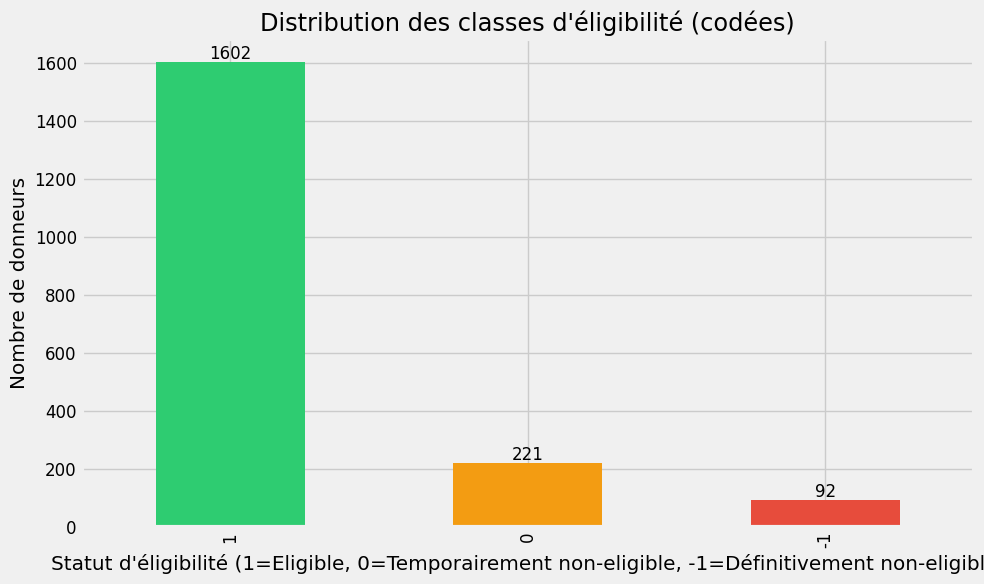

Distribution en pourcentage:
1: 83.7%
0: 11.5%
-1: 4.8%


In [6]:


# Vérifier la distribution de l'éligibilité
eligibility_column = 'eligibilite_code' if 'eligibilite_code' in df.columns else 'ÉLIGIBILITÉ AU DON.'

plt.figure(figsize=(10, 6))
if eligibility_column == 'eligibilite_code':
    counts = df[eligibility_column].value_counts()
    ax = counts.plot(kind='bar', color=['#2ecc71', '#f39c12', '#e74c3c'])
    plt.title('Distribution des classes d\'éligibilité (codées)')
    plt.xlabel('Statut d\'éligibilité (1=Eligible, 0=Temporairement non-eligible, -1=Définitivement non-eligible)')
    plt.ylabel('Nombre de donneurs')
else:
    counts = df[eligibility_column].value_counts()
    ax = counts.plot(kind='bar', color=['#2ecc71', '#f39c12', '#e74c3c'])
    plt.title('Distribution des classes d\'éligibilité')
    plt.xlabel('Statut d\'éligibilité')
    plt.ylabel('Nombre de donneurs')

for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

plt.tight_layout()
plt.show()

# Calculer les pourcentages
percentages = counts / counts.sum() * 100
print("Distribution en pourcentage:")
for label, pct in zip(counts.index, percentages):
    print(f"{label}: {pct:.1f}%")

In [7]:

## 3. Préparation des données pour l'entraînement


# Préparation de la cible
if 'eligibilite_code' in df.columns:
    # Conversion en problème binaire (éligible vs non-éligible)
    y = (df['eligibilite_code'] == 1).astype(int)
    print("Variable cible: eligibilite_code (1=Eligible, 0=Non-eligible)")
elif 'ÉLIGIBILITÉ AU DON.' in df.columns:
    # Conversion des catégories en codes numériques
    y = (df['ÉLIGIBILITÉ AU DON.'] == 'Eligible').astype(int)
    print("Variable cible: ÉLIGIBILITÉ AU DON. (1=Eligible, 0=Non-eligible)")
else:
    raise ValueError("Aucune colonne d'éligibilité trouvée dans les données")

# Afficher la distribution finale
print(f"Distribution de la variable cible: {y.value_counts().to_dict()}")
print(f"Pourcentage de la classe positive (éligible): {y.mean()*100:.1f}%")

Variable cible: eligibilite_code (1=Eligible, 0=Non-eligible)
Distribution de la variable cible: {1: 1602, 0: 313}
Pourcentage de la classe positive (éligible): 83.7%


In [8]:


# Sélection des caractéristiques
# Exclure les colonnes qui ne sont pas utiles pour la prédiction
exclude_cols = [
    'eligibilite_code', 'ÉLIGIBILITÉ AU DON.', 
    'Date de remplissage de la fiche', 'Date de naissance', 
    'Si oui preciser la date du dernier don.',
    'Date de dernières règles (DDR) '
]

feature_cols = [col for col in df.columns if col not in exclude_cols]

# Séparation des caractéristiques numériques et catégorielles
numeric_features = []
categorical_features = []

for col in feature_cols:
    # Vérifier si la colonne existe et a des données
    if col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            numeric_features.append(col)
        else:
            categorical_features.append(col)

print(f"Nombre de caractéristiques numériques: {len(numeric_features)}")
print(f"Nombre de caractéristiques catégorielles: {len(categorical_features)}")

# Afficher les 5 premières caractéristiques de chaque type
print("Exemples de caractéristiques numériques:")
print(numeric_features[:5])
print("Exemples de caractéristiques catégorielles:")
print(categorical_features[:5])

Nombre de caractéristiques numériques: 11
Nombre de caractéristiques catégorielles: 36
Exemples de caractéristiques numériques:
['Taille', 'Poids', 'age', 'Porteur(HIV,hbs,hcv)_indicateur', 'Diabétique_indicateur']
Exemples de caractéristiques catégorielles:
["Niveau d'etude", 'Genre', 'Situation Matrimoniale (SM)', 'Profession', 'Arrondissement de résidence']


Caractéristiques retenues après filtrage des valeurs manquantes:
- Numériques: 2
- Catégorielles: 13
- Total: 15


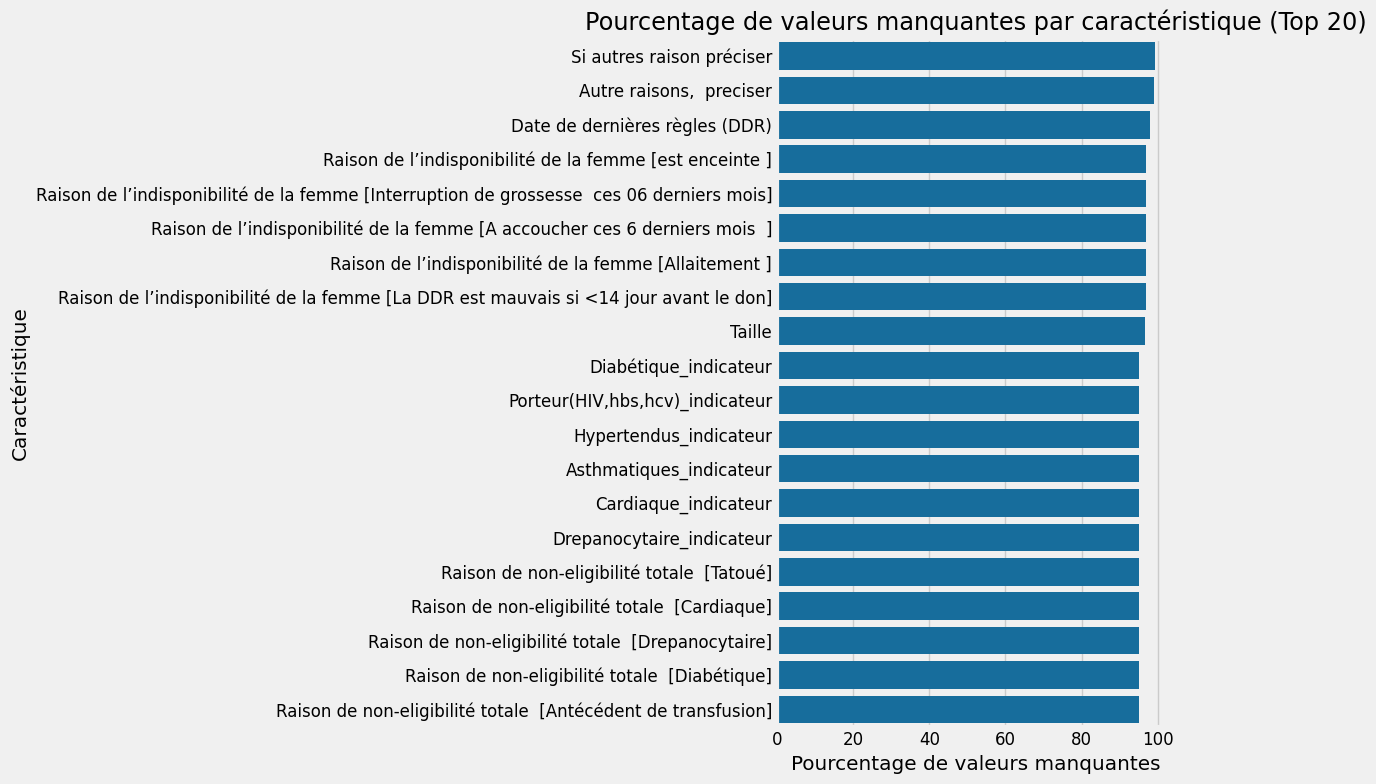

In [9]:


# Filtrer les colonnes avec trop de valeurs manquantes (>50%)
valid_features = []
missing_pct = {}

for col in numeric_features + categorical_features:
    pct_missing = df[col].isna().mean() * 100
    missing_pct[col] = pct_missing
    if pct_missing < 50:  # Moins de 50% de valeurs manquantes
        valid_features.append(col)

# Mise à jour des listes de caractéristiques
numeric_features = [col for col in numeric_features if col in valid_features]
categorical_features = [col for col in categorical_features if col in valid_features]

print(f"Caractéristiques retenues après filtrage des valeurs manquantes:")
print(f"- Numériques: {len(numeric_features)}")
print(f"- Catégorielles: {len(categorical_features)}")
print(f"- Total: {len(numeric_features) + len(categorical_features)}")

# Visualiser les valeurs manquantes des 20 caractéristiques avec le plus de données manquantes
missing_df = pd.DataFrame({'Feature': missing_pct.keys(), 'Missing (%)': missing_pct.values()})
missing_df = missing_df.sort_values('Missing (%)', ascending=False).head(20)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Missing (%)', y='Feature', data=missing_df)
plt.title('Pourcentage de valeurs manquantes par caractéristique (Top 20)')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Caractéristique')
plt.tight_layout()
plt.show()

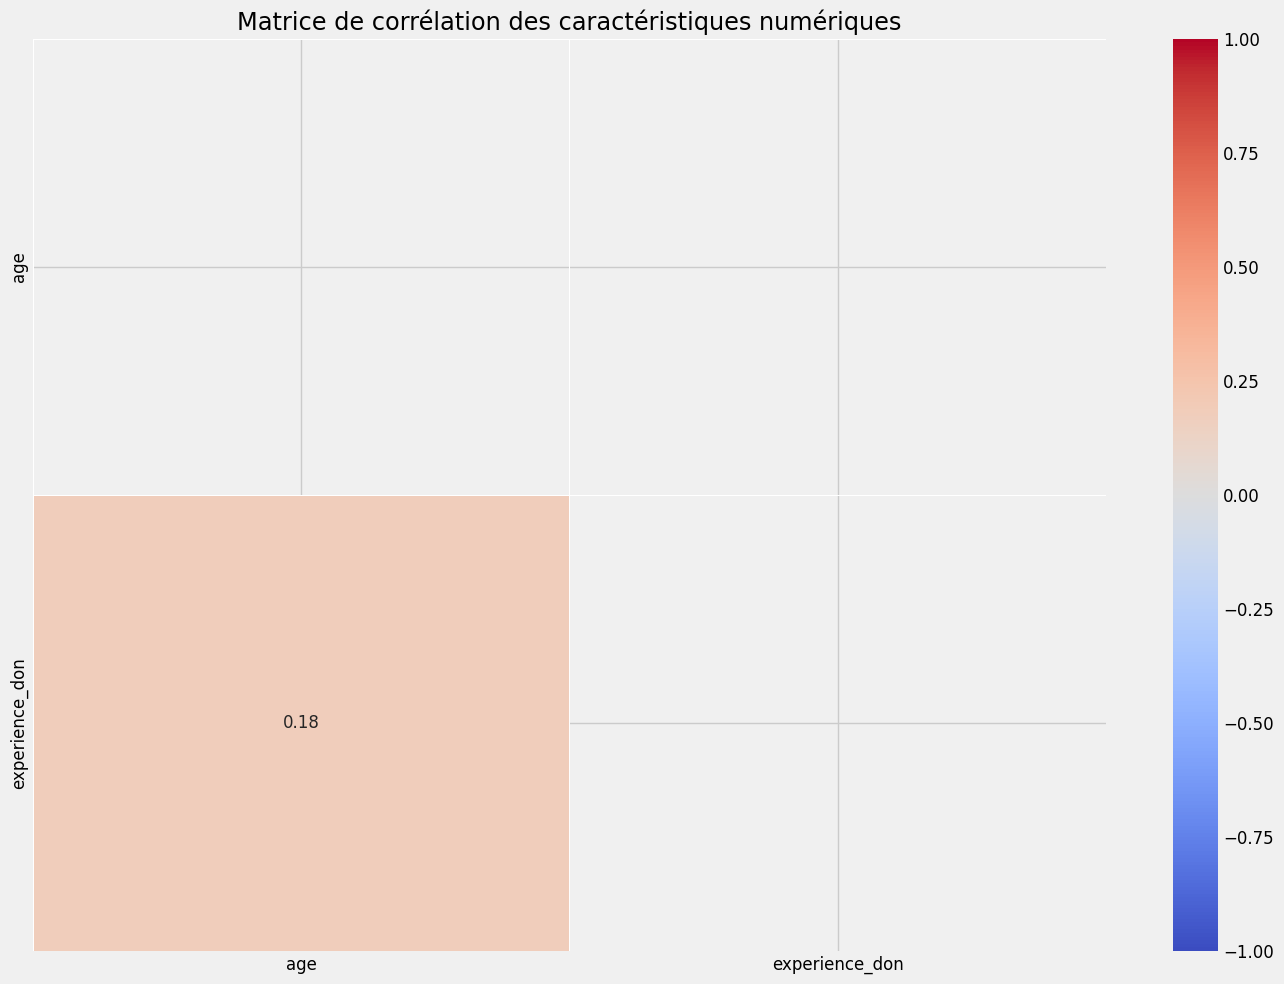

In [10]:


# Analyser les corrélations entre les caractéristiques numériques
if len(numeric_features) > 1:
    plt.figure(figsize=(14, 10))
    corr_matrix = df[numeric_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Matrice de corrélation des caractéristiques numériques')
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de caractéristiques numériques pour calculer les corrélations.")

In [11]:


# Division en ensembles d'entraînement et de test
X = df[numeric_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}")
print(f"Distribution de la cible dans l'ensemble d'entraînement: {y_train.value_counts().to_dict()}")
print(f"Distribution de la cible dans l'ensemble de test: {y_test.value_counts().to_dict()}")

Taille de l'ensemble d'entraînement: (1532, 15)
Taille de l'ensemble de test: (383, 15)
Distribution de la cible dans l'ensemble d'entraînement: {1: 1282, 0: 250}
Distribution de la cible dans l'ensemble de test: {1: 320, 0: 63}


In [12]:

## 4. Création des pipelines de prétraitement et d'entraînement


# Vérifier le déséquilibre des classes
class_counts = y_train.value_counts()
class_imbalance = class_counts.max() / class_counts.min() if class_counts.min() > 0 else float('inf')
use_smote = class_imbalance > 3  # Utiliser SMOTE si déséquilibre significatif

print(f"Ratio de déséquilibre des classes: {class_imbalance:.2f}")
print(f"Utilisation de SMOTE pour rééquilibrer les classes: {use_smote}")

Ratio de déséquilibre des classes: 5.13
Utilisation de SMOTE pour rééquilibrer les classes: True


In [14]:

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
# Préprocesseur pour caractéristiques numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Préprocesseur pour caractéristiques catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinaison des préprocesseurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Ignorer les autres colonnes
)

# Pipeline pour Random Forest
if use_smote:
    rf_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
else:
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

# Pipeline pour Gradient Boosting
if use_smote:
    gb_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
else:
    gb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])

# Pipeline pour XGBoost
if use_smote:
    xgb_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ])
else:
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ])

In [15]:


# Paramètres pour Random Forest
rf_param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

# Paramètres pour Gradient Boosting
gb_param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Paramètres pour XGBoost
xgb_param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5]
}

# Liste des modèles à essayer
models = [
    ('random_forest', rf_pipeline, rf_param_dist),
    ('gradient_boosting', gb_pipeline, gb_param_dist),
    ('xgboost', xgb_pipeline, xgb_param_dist)
]

In [16]:

## 5. Entraînement et optimisation des modèles


# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate(name, pipeline, param_dist, X_train, y_train, X_test, y_test):
    print(f"Optimisation des hyperparamètres pour {name}...")
    start_time = time.time()
    
    # Validation croisée stratifiée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Recherche aléatoire d'hyperparamètres
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist,
        n_iter=10,  # Réduire pour accélérer le notebook, augmenter pour de meilleurs résultats
        cv=cv,
        scoring='f1',  # F1 est une bonne métrique pour les classes déséquilibrées
        n_jobs=-1,  # Utiliser tous les processeurs
        random_state=42,
        verbose=1
    )
    
    # Entraînement
    search.fit(X_train, y_train)
    
    # Temps d'entraînement
    train_time = time.time() - start_time
    
    # Évaluer sur l'ensemble de test
    y_pred = search.predict(X_test)
    y_prob = search.predict_proba(X_test)[:, 1]
    
    # Calculer diverses métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Afficher les résultats
    print(f"Résultats pour {name}:")
    print(f"  Temps d'entraînement: {train_time:.2f} secondes")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Meilleurs paramètres: {search.best_params_}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Classification report
    cr = classification_report(y_test, y_pred, output_dict=True)
    
    # Résumé des résultats
    results = {
        'model': search.best_estimator_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': search.best_params_,
        'confusion_matrix': cm,
        'classification_report': cr,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'train_time': train_time
    }
    
    return results

In [17]:


# Entraîner et évaluer chaque modèle
results = {}

for name, pipeline, params in models:
    try:
        model_results = train_and_evaluate(name, pipeline, params, X_train, y_train, X_test, y_test)
        results[name] = model_results
    except Exception as e:
        print(f"Erreur lors de l'entraînement de {name}: {e}")

Optimisation des hyperparamètres pour random_forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Résultats pour random_forest:
  Temps d'entraînement: 20.53 secondes
  Accuracy: 0.8877
  Precision: 0.8991
  Recall: 0.9750
  F1 Score: 0.9355
  ROC AUC: 0.9106
  Meilleurs paramètres: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 30, 'classifier__class_weight': 'balanced_subsample'}
Optimisation des hyperparamètres pour gradient_boosting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Résultats pour gradient_boosting:
  Temps d'entraînement: 123.65 secondes
  Accuracy: 0.8903
  Precision: 0.9162
  Recall: 0.9563
  F1 Score: 0.9358
  ROC AUC: 0.8816
  Meilleurs paramètres: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
Optim

In [18]:


# Afficher un résumé comparatif des résultats
summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1_score'],
        'ROC AUC': res['roc_auc'],
        'Training Time (s)': res['train_time']
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values('F1 Score', ascending=False)
summary_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
1,gradient_boosting,0.890339,0.916168,0.95625,0.935780,0.881647,123.651400
0,random_forest,0.887728,0.899135,0.97500,0.935532,0.910565,20.531964
2,xgboost,0.882507,0.903226,0.96250,0.931921,0.867708,17.981775


In [19]:
# Trouver le meilleur modèle (selon F1 Score)
best_model_name = summary_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"Meilleur modèle: {best_model_name} avec F1 Score de {results[best_model_name]['f1_score']:.4f}")

Meilleur modèle: gradient_boosting avec F1 Score de 0.9358


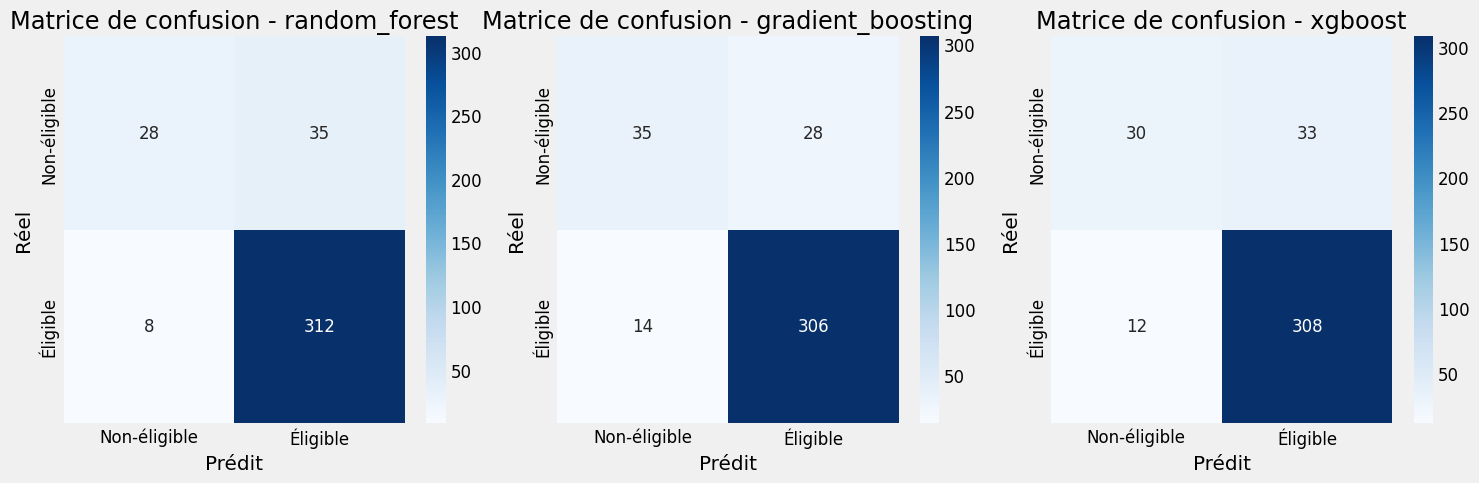

In [20]:
## 6. Visualisation des résultats des modèles

# Visualiser les matrices de confusion
plt.figure(figsize=(15, 5))

for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    cm = res['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-éligible', 'Éligible'],
                yticklabels=['Non-éligible', 'Éligible'])
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')

plt.tight_layout()
plt.show()

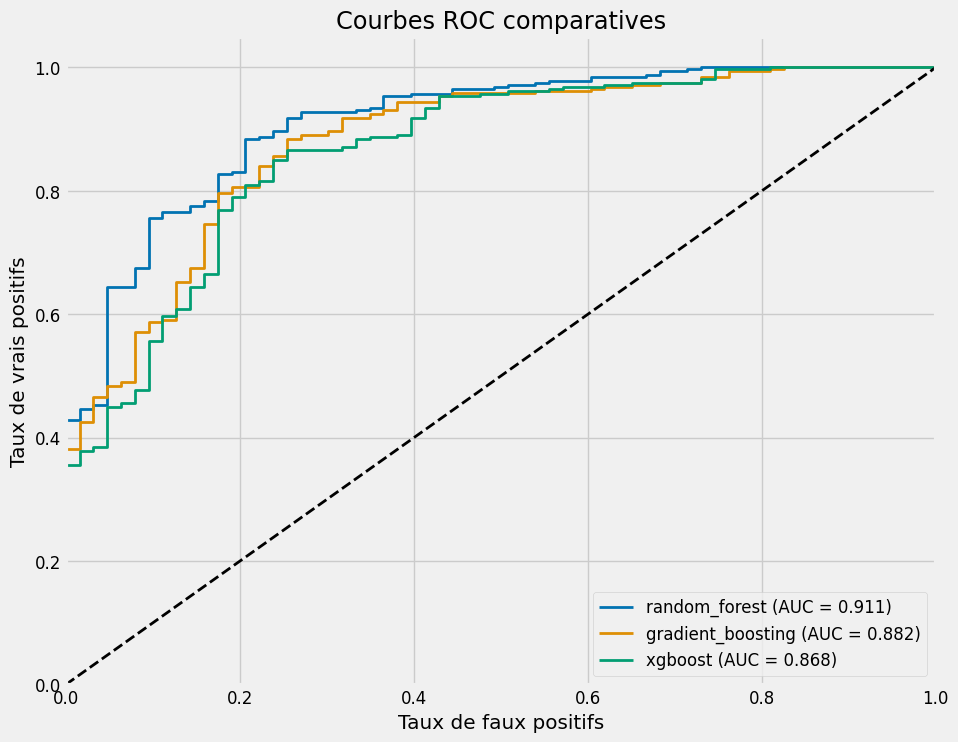

In [21]:


# Visualiser les courbes ROC
plt.figure(figsize=(10, 8))

for name, res in results.items():
    y_prob = res['y_prob']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = res['roc_auc']
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC comparatives')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

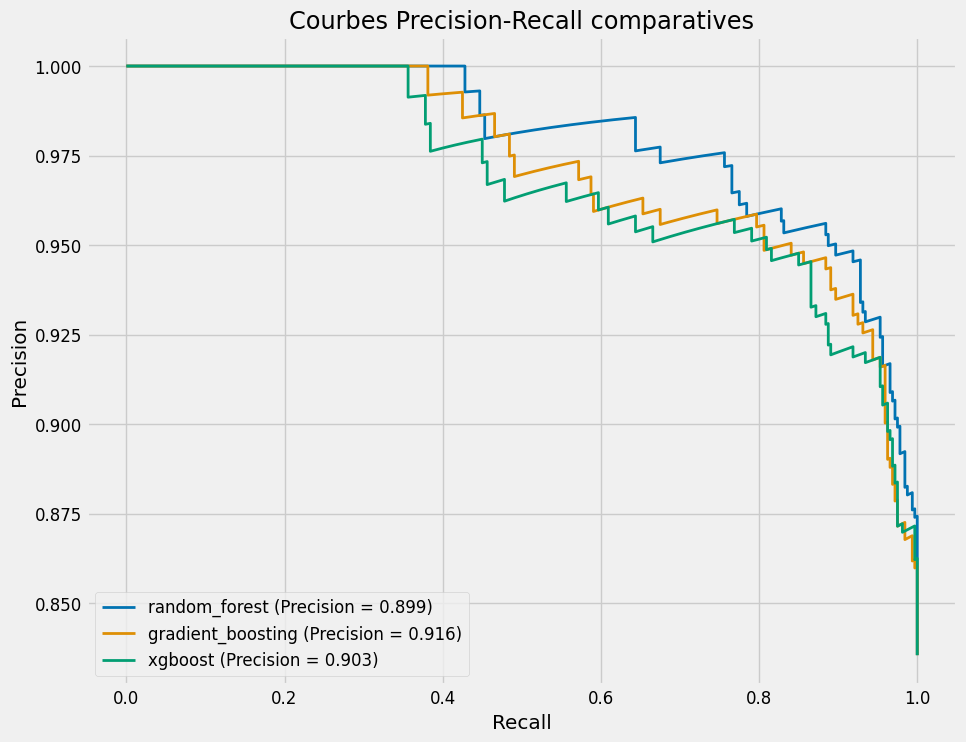

In [22]:
# Visualiser les courbes Precision-Recall
plt.figure(figsize=(10, 8))

for name, res in results.items():
    y_prob = res['y_prob']
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    avg_precision = res['precision']
    
    plt.plot(recall, precision, lw=2, label=f'{name} (Precision = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Precision-Recall comparatives')
plt.legend(loc="best")
plt.grid(True)
plt.show()

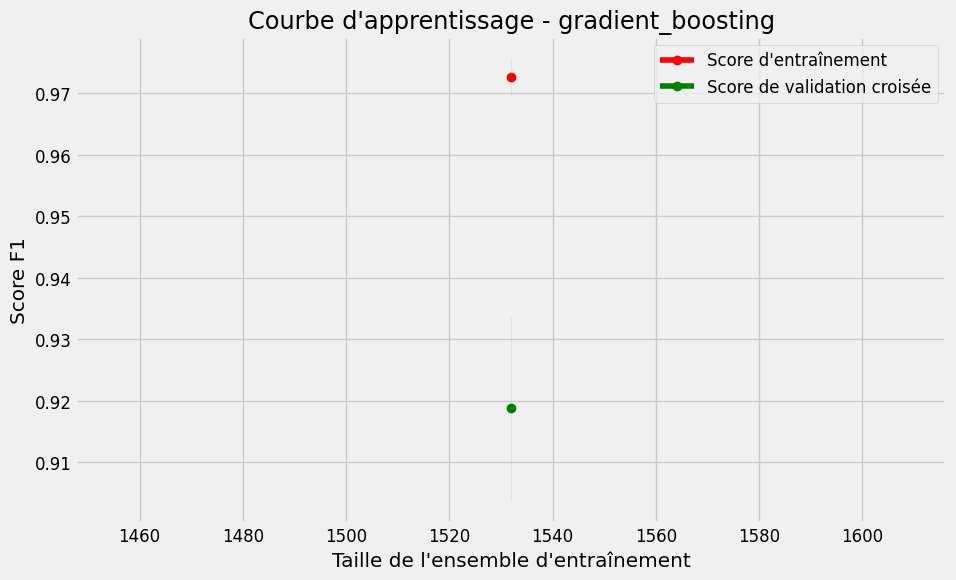

In [23]:
## 7. Analyse approfondie du meilleur modèle


# Extraire le meilleur modèle
best_model = results[best_model_name]['model']

# Tracer les courbes d'apprentissage pour évaluer l'overfitting
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='f1', random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")
    
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score F1")
    plt.title(f"Courbe d'apprentissage - {best_model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Appliquer la courbe d'apprentissage (peut prendre du temps)
plot_learning_curve(best_model, X, y)

In [24]:
# Analyse de l'importance des caractéristiques
def get_feature_importance(model, X, feature_names):
    try:
        # Extraire le modèle final du pipeline
        if 'classifier' in model.named_steps:
            final_model = model.named_steps['classifier']
        else:
            final_model = model
            
        # Obtenir les noms des caractéristiques après transformation
        if 'preprocessor' in model.named_steps:
            preprocessor = model.named_steps['preprocessor']
            # Appliquer le préprocesseur pour obtenir les noms transformés
            X_transformed = preprocessor.transform(X)
            
            # Essayer d'extraire les noms des caractéristiques
            transformed_feature_names = []
            
            # Pour les caractéristiques numériques
            if numeric_features:
                transformed_feature_names.extend(numeric_features)
            
            # Pour les caractéristiques catégorielles
            if categorical_features and hasattr(preprocessor, 'transformers_'):
                for name, transformer, features in preprocessor.transformers_:
                    if name == 'cat' and features:
                        if hasattr(transformer.named_steps['onehot'], 'get_feature_names_out'):
                            cat_features = transformer.named_steps['onehot'].get_feature_names_out(
                                input_features=categorical_features)
                            transformed_feature_names.extend(cat_features)
            
            feature_names = transformed_feature_names if transformed_feature_names else feature_names
        
        # Pour les modèles à base d'arbres
        if hasattr(final_model, 'feature_importances_'):
            importances = final_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            # Si les noms des caractéristiques ne correspondent pas, utiliser des index
            if len(feature_names) != len(importances):
                feature_names = [f"Feature {i}" for i in range(len(importances))]
            
            return pd.DataFrame({
                'Feature': [feature_names[i] for i in indices],
                'Importance': [importances[i] for i in indices]
            })
        else:
            # Utiliser l'importance par permutation pour les autres modèles
            perm_importance = permutation_importance(
                final_model, X_transformed, y_test, n_repeats=10, random_state=42)
            
            importances = perm_importance.importances_mean
            indices = np.argsort(importances)[::-1]
            
            if len(feature_names) != len(importances):
                feature_names = [f"Feature {i}" for i in range(len(importances))]
            
            return pd.DataFrame({
                'Feature': [feature_names[i] for i in indices],
                'Importance': [importances[i] for i in indices]
            })
    
    except Exception as e:
        print(f"Erreur lors de l'extraction de l'importance des caractéristiques: {e}")
        return pd.DataFrame(columns=['Feature', 'Importance'])

In [25]:


# Essayer d'obtenir l'importance des caractéristiques
feature_importance = None
try:
    # Si le modèle est un pipeline avec une étape 'classifier'
    if 'classifier' in best_model.named_steps:
        classifier = best_model.named_steps['classifier']
        # Si le modèle est basé sur des arbres de décision (comme Random Forest ou XGBoost)
        if hasattr(classifier, 'feature_importances_'):
            # Obtenir les noms de caractéristiques après transformation
            if 'preprocessor' in best_model.named_steps:
                preprocessor = best_model.named_steps['preprocessor']
                # Transformer les données pour correspondre à l'entrée du modèle
                X_transformed = preprocessor.transform(X_test)
                # Essayer d'obtenir les noms des caractéristiques transformées
                col_names = []
                
                for transformer_name, _, cols in preprocessor.transformers_:
                    if transformer_name == 'num':
                        col_names.extend(cols)
                    elif transformer_name == 'cat' and cols:
                        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
                        if hasattr(cat_encoder, 'get_feature_names_out'):
                            cat_cols = cat_encoder.get_feature_names_out(input_features=cols)
                            col_names.extend(cat_cols)
                
                if not col_names:
                    col_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
                
                # Obtenir les importances
                importances = classifier.feature_importances_
                
                if len(col_names) == len(importances):
                    feature_importance = pd.DataFrame({
                        'Feature': col_names,
                        'Importance': importances
                    }).sort_values('Importance', ascending=False)
except Exception as e:
    print(f"Erreur lors de l'extraction de l'importance des caractéristiques: {e}")

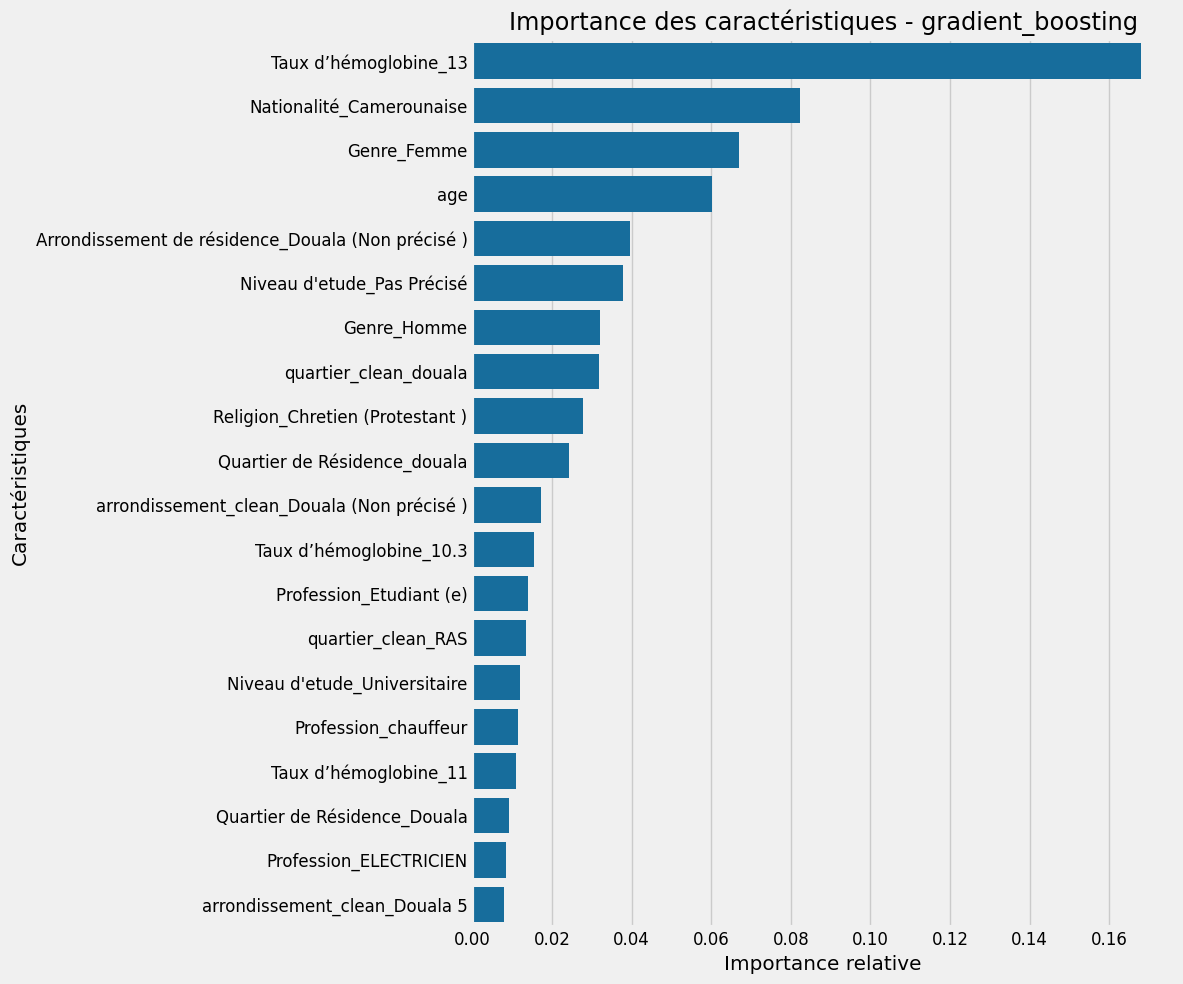

Top 10 des caractéristiques les plus importantes:
                                                Feature  Importance
1080                              Taux d’hémoglobine_13    0.167867
1001                           Nationalité_Camerounaise    0.082409
7                                           Genre_Femme    0.066912
0                                                   age    0.060195
468   Arrondissement de résidence_Douala (Non précisé )    0.039465
3                            Niveau d'etude_Pas Précisé    0.037914
8                                           Genre_Homme    0.032046
1643                              quartier_clean_douala    0.031750
1019                    Religion_Chretien (Protestant )    0.027732
969                        Quartier de Résidence_douala    0.024202


In [26]:


# Visualiser l'importance des caractéristiques
if feature_importance is not None and not feature_importance.empty:
    # Prendre les 20 caractéristiques les plus importantes
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f"Importance des caractéristiques - {best_model_name}")
    plt.xlabel('Importance relative')
    plt.ylabel('Caractéristiques')
    plt.tight_layout()
    plt.show()
    
    # Afficher le tableau des importances des 10 principales caractéristiques
    print("Top 10 des caractéristiques les plus importantes:")
    print(feature_importance.head(10))
else:
    # Alternative: utiliser permutation_importance pour les modèles sans feature_importances_ natif
    try:
        if 'preprocessor' in best_model.named_steps:
            X_processed = best_model.named_steps['preprocessor'].transform(X_test)
        else:
            X_processed = X_test
        
        r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
        
        importance_df = pd.DataFrame({
            'Feature': X.columns if len(X.columns) == len(r.importances_mean) else [f"Feature_{i}" for i in range(len(r.importances_mean))],
            'Importance': r.importances_mean
        }).sort_values('Importance', ascending=False)
        
        # Prendre les 20 caractéristiques les plus importantes
        top_features = importance_df.head(20)
        
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f"Importance des caractéristiques (Permutation) - {best_model_name}")
        plt.xlabel('Importance (diminution de score)')
        plt.ylabel('Caractéristiques')
        plt.tight_layout()
        plt.show()
        
        # Afficher le tableau des importances des 10 principales caractéristiques
        print("Top 10 des caractéristiques les plus importantes (méthode de permutation):")
        print(importance_df.head(10))
    except Exception as e:
        print(f"Impossible de calculer l'importance des caractéristiques: {e}")

In [27]:
## 8. Sauvegarder le modèle final


# Créer un dossier pour sauvegarder le modèle s'il n'existe pas
output_dir = "model"
os.makedirs(output_dir, exist_ok=True)

# Nom du fichier avec horodatage
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"eligibility_model_{best_model_name}_{timestamp}.pkl"
model_path = os.path.join(output_dir, model_filename)

# Sauvegarder le modèle
try:
    joblib.dump(best_model, model_path)
    print(f"Modèle sauvegardé avec succès à: {model_path}")
    
    # Sauvegarder un fichier d'informations sur le modèle
    model_info = {
        'model_name': best_model_name,
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1_score': results[best_model_name]['f1_score'],
        'roc_auc': results[best_model_name]['roc_auc'],
        'training_date': timestamp,
        'features': numeric_features + categorical_features,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'best_params': results[best_model_name]['best_params']
    }
    
    # Sauvegarder les informations du modèle
    info_path = os.path.join(output_dir, f"model_info_{timestamp}.json")
    with open(info_path, 'w') as f:
        import json
        json.dump(model_info, f, indent=4)
    
    print(f"Informations du modèle sauvegardées à: {info_path}")
    
    # Sauvegarder également le tableau récapitulatif des performances des modèles
    summary_path = os.path.join(output_dir, f"model_comparison_{timestamp}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Comparaison des modèles sauvegardée à: {summary_path}")
    
except Exception as e:
    print(f"Erreur lors de la sauvegarde du modèle: {e}")

Modèle sauvegardé avec succès à: model\eligibility_model_gradient_boosting_20250323_104955.pkl
Informations du modèle sauvegardées à: model\model_info_20250323_104955.json
Comparaison des modèles sauvegardée à: model\model_comparison_20250323_104955.csv


In [ ]:
## 9. Fonction de prédiction pour de nouvelles données


def predict_eligibility(model, input_data, threshold=0.5):

    # Convertir le dictionnaire en DataFrame si nécessaire
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data
    
    # Faire la prédiction
    try:
        # Probabilité de la classe positive
        probability = model.predict_proba(input_df)[0][1]
        
        # Prédiction binaire en fonction du seuil
        prediction = int(probability >= threshold)
        
        # Confiance: probabilité de la classe prédite
        confidence = probability if prediction == 1 else 1 - probability
        
        # Mapper à des valeurs humainement lisibles
        status = "Éligible" if prediction == 1 else "Non éligible"
        
        return status, probability, confidence * 100
    except Exception as e:
        print(f"Erreur lors de la prédiction: {e}")
        return None, None, None

In [ ]:


# Exemple d'utilisation de la fonction de prédiction
# Créer un exemple de données d'entrée (à adapter en fonction des caractéristiques du modèle)
example_input = {
    'age': 35,  # Si 'age' fait partie des caractéristiques
    'Genre': 'Homme'  # Si 'Genre' fait partie des caractéristiques catégorielles
}

# Compléter avec des valeurs par défaut pour toutes les caractéristiques utilisées
for feature in numeric_features:
    if feature not in example_input:
        # Utiliser la moyenne comme valeur par défaut
        example_input[feature] = X_train[feature].mean() if feature in X_train else 0

for feature in categorical_features:
    if feature not in example_input:
        # Utiliser la valeur la plus fréquente comme valeur par défaut
        example_input[feature] = X_train[feature].mode()[0] if feature in X_train else ""

# Faire une prédiction
status, probability, confidence = predict_eligibility(best_model, example_input)

print(f"Prédiction: {status}")
print(f"Probabilité d'être éligible: {probability:.4f} ({probability*100:.1f}%)")
print(f"Confiance: {confidence:.1f}%")

In [30]:
## 10. Conclusion et recommandations


# Résumé des performances du modèle
print("Résumé des performances du modèle final")
print("======================================")
print(f"Modèle sélectionné: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Precision: {results[best_model_name]['precision']:.4f}")
print(f"Recall: {results[best_model_name]['recall']:.4f}")
print(f"F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
print("Matrice de confusion:")
print(results[best_model_name]['confusion_matrix'])

# Conseils d'interprétation
print("Interprétation des résultats:")
print("- Precision: Pourcentage de prédictions 'Éligible' correctes")
print("- Recall: Pourcentage de donneurs réellement éligibles correctement identifiés")
print("- F1 Score: Équilibre entre precision et recall")
print("- ROC AUC: Capacité générale du modèle à distinguer les classes")

# Recommandations
print("Recommandations:")
print("1. Utiliser ce modèle pour un pré-screening des donneurs potentiels")
print("2. Se concentrer sur les caractéristiques les plus importantes identifiées")
print("3. Continuer à collecter des données pour améliorer le modèle")
print("4. Réévaluer régulièrement les performances du modèle avec de nouvelles données")

Résumé des performances du modèle final
Modèle sélectionné: gradient_boosting
Accuracy: 0.8903
Precision: 0.9162
Recall: 0.9563
F1 Score: 0.9358
ROC AUC: 0.8816
Matrice de confusion:
[[ 35  28]
 [ 14 306]]
Interprétation des résultats:
- Precision: Pourcentage de prédictions 'Éligible' correctes
- Recall: Pourcentage de donneurs réellement éligibles correctement identifiés
- F1 Score: Équilibre entre precision et recall
- ROC AUC: Capacité générale du modèle à distinguer les classes
Recommandations:
1. Utiliser ce modèle pour un pré-screening des donneurs potentiels
2. Se concentrer sur les caractéristiques les plus importantes identifiées
3. Continuer à collecter des données pour améliorer le modèle
4. Réévaluer régulièrement les performances du modèle avec de nouvelles données


In [ ]:

## Intégration avec le tableau de bord

def load_model():
    model_path = "api/model/eligibility_model_XXXX.pkl"  # Remplacer par le chemin du modèle sauvegardé
    try:
        model = joblib.load(model_path)
        return model
    except Exception as e:
        st.error(f"Erreur lors du chargement du modèle: {e}")
        return None


3. Utilisez la fonction de prédiction fournie dans la section "Prédiction d'éligibilité" du tableau de bord.

Ce notebook vous permet d'entraîner un modèle optimisé pour prédire l'éligibilité au don de sang, d'évaluer ses performances et de l'intégrer facilement dans votre tableau de bord Streamlit.
